```
from dPCA import dPCA
По обученной сети создается тензор
actR = размером(num_trial, hidden_size, S, T)
num_trial - число испытаний для каждого значения стимула
hidden_size - число нейронов сети
S - число стимулов (берем 10)
T - число временных отсчетов в одном испытании

from dPCA import dPCA

R = mean(actR,0)
R -= mean(R.reshape((hidden_size,-1)),1)[:,None,None]
dpca = dPCA.dPCA(labels='st',regularizer='auto')
dpca.protect = ['t']
Z = dpca.fit_transform(R, actR)

time = arange(T) 
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
for s in range(S) :
    ax1.plot(time, Z['t'][0,s]) 
for s in range(S) :
    ax2.plot(time, Z['s'][0,s])
for s in range(S) :
    ax3.plot(time, Z['st'][0,s])
    ```

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from norse.torch.functional.lif import LIFParameters
from tqdm import tqdm

from dPCA import dPCA
from cgtasknet.instruments.instrument_pca import PCA
from cgtasknet.net.lifrefrac import SNNLifRefrac
from norse.torch.functional.lif_refrac import LIFRefracParameters

from cgtasknet.net.states import LIFRefracInitState
from cgtasknet.tasks.reduce import DefaultParams, DMTask

input_values = [0, 0.1, 0.2, 0.3, 0.4, 0.49, 0.51, 0.6, 0.7, 0.8, 0.9, 1]
feature_size = 2
output_size = 3
hidden_size = 401
batch_size = 1
neuron_parameters = LIFRefracParameters(
    LIFParameters(
        alpha=torch.as_tensor(100), method="super", v_th=torch.as_tensor(0.65)
    ),
    rho_reset=torch.as_tensor(1),
)
model = SNNLifRefrac(
    feature_size,
    hidden_size,
    output_size,
    neuron_parameters=neuron_parameters,
    tau_filter_inv=500,
    save_states=True,
)
if True:
    model.load_state_dict(
        torch.load(
            "..\models\\only_dm_lif_refrac\\max_accuracy\\_lr_0.001_N_401_number_1990"
        )
    )
init_state = LIFRefracInitState(batch_size, hidden_size)
first_state = init_state.zero_state()
second_state = init_state.random_state()
v_mean = None
number_of_trials = 10
data_save = torch.zeros((0, 1, 2))
dmparams = DefaultParams("DMTask").generate_params()
actR = np.zeros(
    (
        number_of_trials,
        hidden_size,
        len(input_values),
        int((dmparams["delay"]) / dmparams["dt"]),
    )
)
for trial in tqdm(range(number_of_trials)):
    v_save = torch.zeros((0, 1, hidden_size))
    for value in range(len(input_values)):
        dmparams = DefaultParams("DMTask").generate_params()
        dmparams["value"] = input_values[value]
        Task = DMTask(dmparams, mode="value")
        data, _ = Task.dataset(1)
        data = torch.from_numpy(data).type(torch.float)
        out, states = model(data, first_state)
        v = []
        s = []
        # i = []
        for j in range(len(states)):
            v.append(states[j].lif.v)
            s.append(states[j].lif.z)
            # i.append(states[j].lif.i)
        v = torch.stack(v).detach()
        actR[trial, :, value, :] = v[
            -int((dmparams["delay"]) / dmparams["dt"]) :, 0, :
        ].T.numpy()
        v_save = torch.concat((v_save, v), axis=0)
        if trial == 0:
            data_save = torch.concat((data_save, data), axis=0)
    if v_mean is None:
        v_mean = torch.zeros_like(v_save)
    v_mean += v_save
v_mean /= float(number_of_trials)


pca = PCA(3).decompose(v_mean.reshape(v_mean.shape[0], v_mean.shape[2]))


s = torch.stack(s).detach()
s = s.cpu().numpy()

100%|██████████| 10/10 [00:50<00:00,  5.03s/it]


You chose to determine the regularization parameter automatically. This can
                    take substantial time and grows linearly with the number of crossvalidation
                    folds. The latter can be set by changing self.n_trials (default = 3). Similarly,
                    use self.protect to set the list of axes that are not supposed to get to get shuffled
                    (e.g. upon splitting the data into test- and training, time-points should always
                    be drawn from the same trial, i.e. self.protect = ['t']). This can significantly
                    speed up the code.
Start optimizing regularization.
Starting trial  1 / 3
Starting trial  2 / 3
Starting trial  3 / 3
Optimized regularization, optimal lambda =  7.937147732541432e-06
Regularization will be fixed; to compute the optimal                    parameter again on the next fit, please                    set opt_regularizer_flag to True.


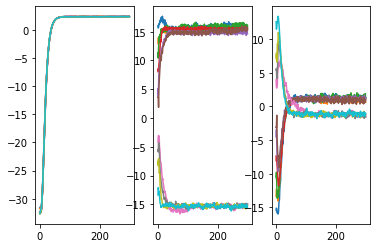

In [4]:
R = np.mean(actR, 0)
R -= np.mean(R.reshape((hidden_size, -1)), 1)[:, None, None]
dpca = dPCA.dPCA(labels="st", regularizer="auto")
dpca.protect = ["t"]
Z = dpca.fit_transform(R, actR)

time = np.arange(actR.shape[-1])
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
for s in range(actR.shape[0]):
    ax1.plot(time, Z["t"][0, s])
for s in range(actR.shape[0]):
    ax2.plot(time, Z["s"][0, s])
for s in range(actR.shape[0]):
    ax3.plot(time, Z["st"][0, s])

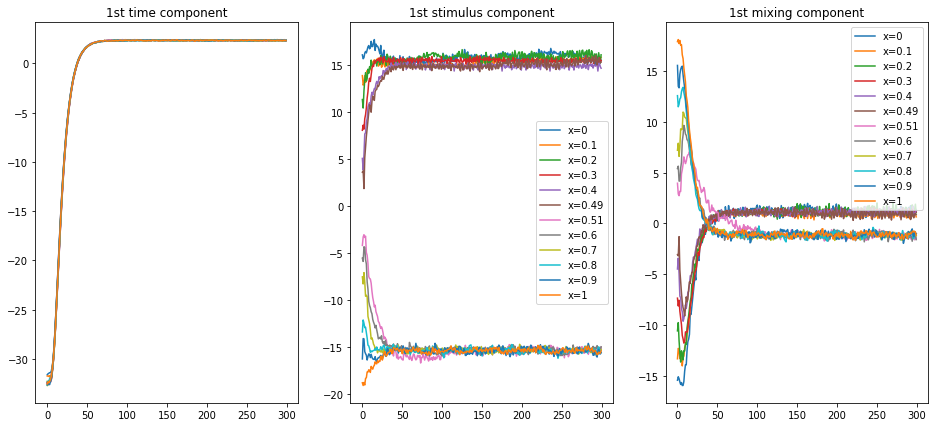

In [5]:
plt.figure(figsize=(16, 7))
plt.subplot(131)
S = actR.shape[2]
for s in range(S):
    plt.plot(time, Z["t"][0, s])

plt.title("1st time component")

plt.subplot(132)

for s in range(S):
    plt.plot(time, Z["s"][0, s], label=f"x={input_values[s]}")
plt.legend()
plt.title("1st stimulus component")

plt.subplot(133)

for s in range(S):
    plt.plot(time, Z["st"][0, s], label=f"x={input_values[s]}")
plt.legend()
plt.title("1st mixing component")
plt.savefig("во время отклика dpca.pdf")
plt.show()

In [34]:
actR.shape

(10, 401, 12, 300)

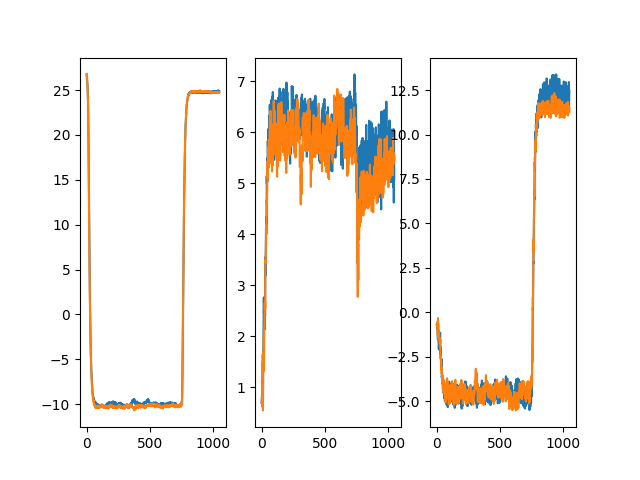

In [24]:
time = np.arange(actR.shape[-1])
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
for s in range(actR.shape[0]):
    ax1.plot(time, Z["t"][0, s])
for s in range(actR.shape[0]):
    ax2.plot(time, Z["s"][0, s])
for s in range(actR.shape[0]):
    ax3.plot(time, Z["st"][0, s])

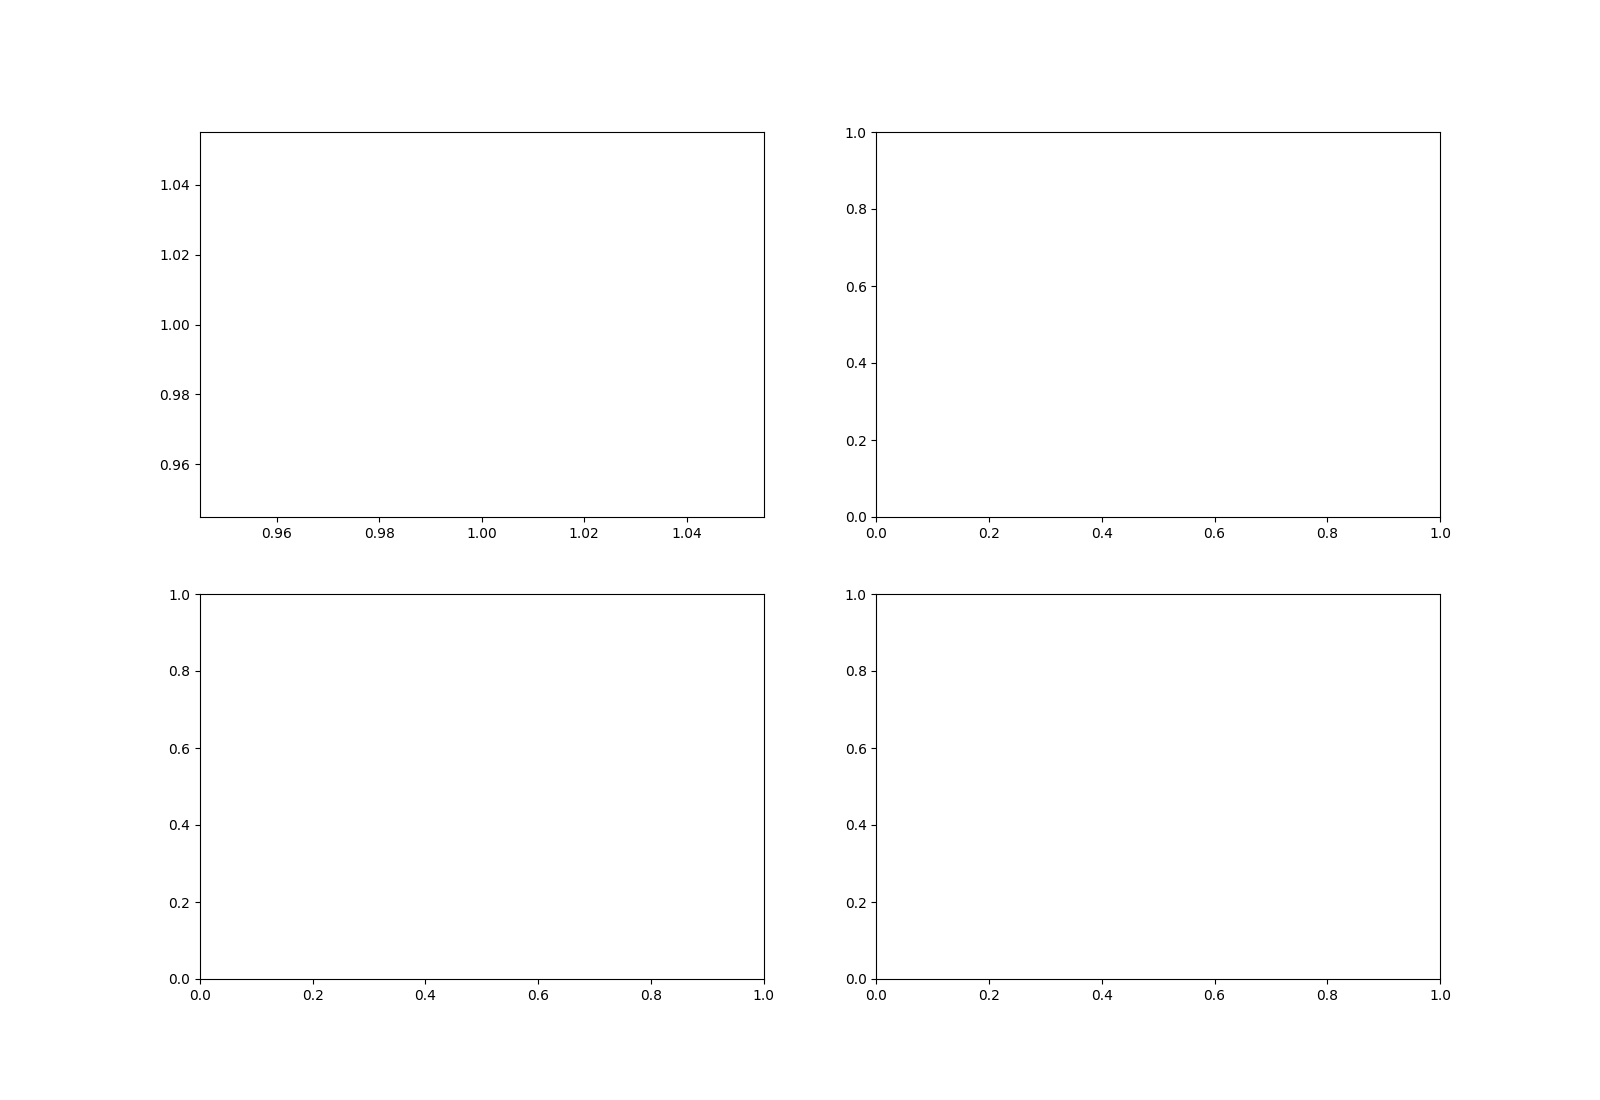

In [6]:
%matplotlib widget
plt.ion
fig = plt.figure(figsize=(16, 11))
ax = fig.add_subplot(221)

ax2 = fig.add_subplot(223)

(line,) = ax.plot(1, 1)
(line2,) = ax.plot(1, 1)
fig.canvas.draw()
fig.canvas.flush_events()

ax3 = fig.add_subplot(222)
ax4 = fig.add_subplot(224)
# plt.tight_layout()

In [10]:
import time

start = 0
step = 70
c = [i for i in range(start, len(pca), step)]


def update():
    for i in range(start, len(pca), step):
        first = 0
        second = 1
        third = 2

        # plt.clf()
        ax.set_xlim(-40, 12)
        ax.set_ylim(-18, 18)

        ax2.set_xlim([0, len(pca)])
        ax2.set_ylim([-0.5, 1.5])
        ax.clear()
        ax2.clear()
        ax3.clear()
        ax4.clear()

        ax.scatter(
            pca.numpy()[start:i, first],
            pca.numpy()[start:i, second],
            cmap="jet",
            c=[j for j in range(i - start)],
            s=2,
        )

        ax2.clear()
        ax2.plot(data_save[:i, 0, 1].numpy(), c="black")

        ax3.plot(pca.numpy()[start:i, first], c="black")
        ax4.plot(pca.numpy()[start:i, second], c="black")

        ax.set_xlabel("$PC_1$")
        ax.set_ylabel("$PC_2$")
        # ax.set_zlabel("$PC_3$")
        ax2.set_xlabel("Time, ms")
        ax2.set_ylabel("Input")
        ax3.set_xlabel("Time, ms")
        ax3.set_ylabel("$PC_1$")
        ax4.set_xlabel("Time, ms")
        ax4.set_ylabel("$PC_2$")

        fig.canvas.draw()
        fig.canvas.flush_events()
        # time.sleep(.001)


# while True:
update()

KeyboardInterrupt: 

In [ ]:
data_save.shape

torch.Size([0, 1, 2])

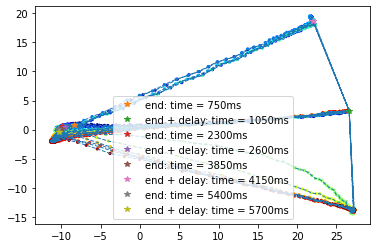

In [ ]:
cmap = np.arange(0, len(v_mean))
first = 0
second = 1
plt.plot(pca.numpy()[:, first], pca.numpy()[:, second], "--", linewidth=1)
plt.scatter(pca.numpy()[:, first], pca.numpy()[:, second], c=cmap, cmap="jet", s=5)


trialstop = 750
delay = 300
delay_beetween = 500
time = trialstop
for i in range(4):

    plt.plot(
        pca.numpy()[time, first],
        pca.numpy()[time, second],
        "*",
        label=rf"end: time = {time}ms",
    )
    time += delay
    plt.plot(
        pca.numpy()[time, first],
        pca.numpy()[time, second],
        "*",
        label=rf"end + delay: time = {time}ms",
    )

    time += delay_beetween + trialstop


plt.legend()
plt.show()

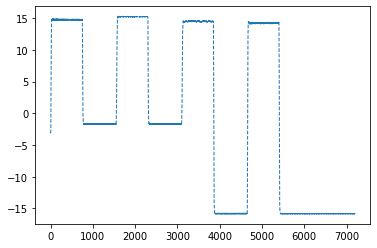

In [ ]:
plt.plot(pca.numpy()[:, 0], "--", linewidth=1)

plt.show()

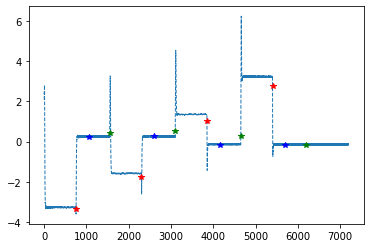

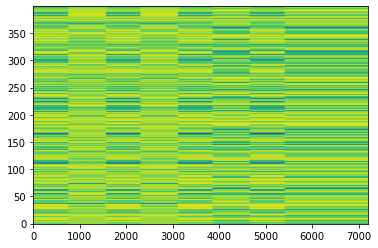

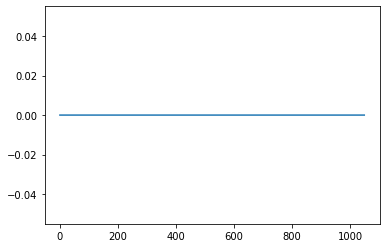

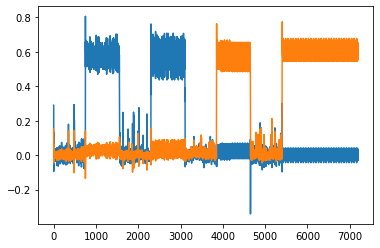

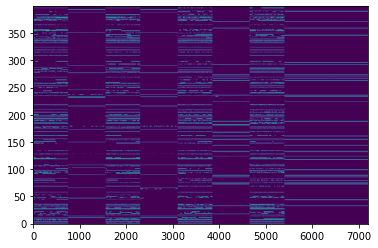

In [ ]:
pca_show = 2
plt.plot(pca.numpy()[:, pca_show], "--", linewidth=1)
trialstop = 750
delay = 300
delay_beetween = 500
time = trialstop
for i in range(4):

    plt.plot([time], pca.numpy()[time, pca_show], "*", c="r")
    time += delay
    plt.plot(
        [time],
        pca.numpy()[time, pca_show],
        "*",
        c="b",
    )
    time += delay_beetween
    plt.plot(
        [time],
        pca.numpy()[time, pca_show],
        "*",
        c="g",
    )
    time += trialstop
plt.show()

plt.imshow(v_mean.numpy()[:, 0, :].T, aspect="auto", origin="lower")
plt.show()

inputs, target_out = Task.dataset(1)

plt.plot(inputs[:, 0, 1])
plt.show()

# plt.plot(out[:, 0, 0])
plt.plot(out[:, 0, 1])
plt.plot(out[:, 0, 2])
plt.show()


plt.imshow(s[:, 0, :].T, aspect="auto", origin="lower", vmax=0.8)
plt.show()